<a href="https://colab.research.google.com/github/lw-miles24/CompModNervSys-final/blob/main/simulate_BallAndStick_soma_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll first install neuron as usual.

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 31.1 MB/s eta 0:00:00


Run the code block below to mount the google drive folder with the rest of the model files. Save your files in a folder in your main google drive folder and set `drive_folder_name` equal to it as a string. It also compiles the mod files in the `mechanisms` folder

In [1]:
repo_name = 'CompModNervSys-final'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/lw-miles24/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

/content/CompModNervSys-final
Mod files: "mechanisms/mechanisms/kv.mod" "mechanisms/mechanisms/na.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Now we can import the packages we'll be using

In [19]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.stats import norm
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()


Create the Ball and Stick neuron model

In [3]:
from ballandstick import BallAndStick

ais_mode = 'soma' # set to either 'soma' or 'dend'
ais_loc = 0.6 # 0 to 1, if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
ais_length = 100
cell = BallAndStick(0,ais_mode,ais_loc,ais_length)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell.soma(0.5))
iclamp.delay = 5 # ms
iclamp.dur = 5 # ms
iclamp.amp = 1 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
       `--------------------|       BallAndStick[0].ais_prox(0-1)
                             `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                   `------------------------|       BallAndStick[0].axon(0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)



Add excitatory synapse to basal dendritic branch with AIS (`dend[0]`), distal to AIS. Add inhibitory synapse to soma. (see Exercise 9 for detail instructions on how to make synapses)

In [59]:
# Add synapses, in line with Hodapp et al. 2022...
exc_weight = 0
inh_weight = 0

num_syn = 1000
exc_loc_spread = [75,100] # µm from soma, along basal dendrite
exc_fdhm = 4 # ms

exc_locs = np.linspace(exc_loc_spread[0]/cell.dend[0].L,exc_loc_spread[1]/cell.dend[0].L,num_syn)

# pseudorandom activation times: Gaussian curve with specified full-duration at half-maximum
time_points = norm.ppf(np.linspace(0.001,0.999,num_syn))
exc_times = time_points * exc_fdhm + 20
inh_fdhm = exc_fdhm * (2/3) # ms
inh_times = time_points * inh_fdhm + 22.5

exc_syns = []
inh_syns = []

for i in np.arange(1,num_syn):

    # 1000 excitatory synapses distributed evenly between 75 and 100 µm (0.375 - 0.5)
    exc_syn_i = h.Exp2Syn(cell.dend[0](exc_locs[i]))
    exc_syn_i.tau1 = 0.175 # ms - rise time
    exc_syn_i.tau2 = 5 # ms - decay time
    exc_syn_i.e = 0 # mV - 4eversal potential
    exc_syns.append(exc_syn_i)

    estim_i = h.NetStim()
    estim_i.number = i
    estim_i.interval = 10 # ms
    estim_i.start = exc_times[i] # ms
    estim_i.noise = 0

    nc_estim_i = h.NetCon(estim_i,exc_syn_i)
    nc_estim_i.delay = 1 # ms - synaptic delay
    nc_estim_i.weight[0] = exc_weight/num_syn # µS - peak conductance

    # 1000 inhibitory synapses at soma
    inh_syn_i = h.Exp2Syn(cell.soma(0.5))
    inh_syn_i.tau1 = 1.6 # ms
    inh_syn_i.tau2 = 11 # ms
    inh_syn_i.e = -75 # mV
    inh_syns.append(inh_syn_i)

    # NetStim to simulate inhibitory presynaptic spikes
    istim_i = h.NetStim()
    istim_i.number = i
    istim_i.interval = 10 # ms - interval between spikes
    istim_i.start = 5 # ms
    istim_i.noise = 0

    # NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
    nc_istim_i = h.NetCon(istim_i,inh_syn_i)
    nc_istim_i.delay = 1 # ms - synaptic delay
    nc_istim_i.weight[0] = inh_weight/num_syn # µS - peak conductance

In [50]:
# set up synaptic current recordings
exc_syn_i = np.zeros(int(h.tstop/h.dt))
exc_syn_g = np.zeros(int(h.tstop/h.dt))
inh_syn_i = np.zeros(int(h.tstop/h.dt))
inh_syn_g = np.zeros(int(h.tstop/h.dt))
for i in np.arange(1,num_syn):
    exc_syn_i = exc_syn_i + h.Vector().record(exc_syns[i]._ref_i)
    exc_syn_g = exc_syn_g + h.Vector().record(exc_syns[i]._ref_g)
    inh_syn_i = inh_syn_i + h.Vector().record(inh_syns[i]._ref_i)
    inh_syn_g = inh_syn_g + h.Vector().record(inh_syns[i]._ref_g)

ValueError: setting an array element with a sequence.

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

Define helper function to convert between `x` values (normalized distance along a cable) and the segment index (a number between `0` and `nseg-1`) within the dendrite.

In [6]:
def xind(vec,val):
    # finds closest value to x in x_vals vector, outputs index
    # if x>1, outputs index for x = 1, and if x<0, outputs index for x = 0
    return np.argmin(np.abs(vec-val))

dend0_x_vals = np.array([seg.x for seg in cell.dend[0]])
dend1_x_vals = np.array([seg.x for seg in cell.dend[1]])

# def apfire_thresh(v_vec):
    # from Hodapp et al. 2022, AP defined as the mV where dV > 10 mV/ms
    # if neuron did not fire, returns 100 mV
#     for v_vec

Set amplitude of current pulse, excitatory synapse, and/or inhibitory synapse, run, and plot

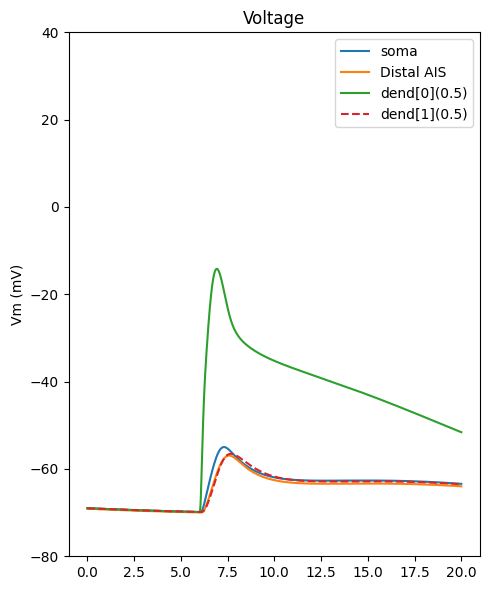

In [60]:
iclamp.amp=0
h.run()

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(111) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')
# Uncomment to plot other voltages
ax0.plot(t_vec,cell.ais_v,label='Distal AIS')
ax0.plot(t_vec,cell.dend0_vs[xind(dend0_x_vals,0.5)],label='dend[0](0.5)')
ax0.plot(t_vec,cell.dend1_vs[xind(dend1_x_vals,0.5)],label='dend[1](0.5)',ls='--')
# ax0.legend()
ax0.set_ylim(-80,40)
ax0.set_ylabel('Vm (mV)')
ax0.set_title('Voltage')
ax0.legend()
# ax1 = fig.add_subplot(312) # injected current
# ax1.plot(t_vec,iclamp_i)
# ax1.set_ylabel('Current (nA)')
# ax1.set_title('Somatic current injection')
# ax2 = fig.add_subplot(212)
# ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
# ax2.set_ylabel('Conductance (uS)')
# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')
# ax2.set_xlabel('time (ms)')
# ax2.legend()
# ax2.set_title('Synaptic currents')
fig.tight_layout()

# print(apfire_thresh(cell.ais_v))